In [1]:
%matplotlib inline
import pandas as pd
from pandas import Series
import numpy as np
from functools import reduce
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Lambda
from keras.initializers import glorot_normal
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from numpy import array
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import recall_score, precision_score, precision_recall_fscore_support
import sqlite3
import keras
from scipy.special import softmax
from sklearn.metrics import accuracy_score

/Users/seungwooson/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%%capture
from tqdm import tqdm_notebook
from tqdm import tnrange

In [4]:
df_final = pd.read_csv("data_cleaned_new_features.csv")

In [5]:
df_final['season'] = pd.factorize(df_final['season'])[0]

In [6]:
home_team_stats = ['home_buildUpPlaySpeed', 'home_buildUpPlayDribbling',
       'home_buildUpPlayPassing', 'home_chanceCreationPassing',
       'home_chanceCreationCrossing', 'home_chanceCreationShooting',
       'home_defencePressure', 'home_defenceAggression',
       'home_defenceTeamWidth']
away_team_stats = ['away_buildUpPlaySpeed', 'away_buildUpPlayDribbling',
       'away_buildUpPlayPassing', 'away_chanceCreationPassing',
       'away_chanceCreationCrossing', 'away_chanceCreationShooting',
       'away_defencePressure', 'away_defenceAggression',
       'away_defenceTeamWidth']
attributes_col = ['overall_rating', 'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']
attributes_col.remove("preferred_foot")
attributes_col.remove("attacking_work_rate")
attributes_col.remove("defensive_work_rate")
def nameColumns(playerNum, homeOrAway):
    cols = attributes_col
    player_cols = []
    for col in cols:
        player_cols.append(homeOrAway + "_player_" + str(playerNum) + "_" + col)
    return player_cols
home_player_num = []
away_player_num = []
for i in range(1, 12):
    home_player_num.append(nameColumns(homeOrAway='home', playerNum=i))
    away_player_num.append(nameColumns(homeOrAway='away', playerNum=i))
home_player_num = np.array(home_player_num).flatten()
away_player_num = np.array(away_player_num).flatten()
home_record = ['home_win_record', 'home_loss_record', 'home_draw_record']
away_record = ['away_win_record', 'away_loss_record', 'away_draw_record']

In [7]:
from collections import Counter
home_players_y, away_players_y = [], []
for i in range(1, 12):
    home_players_y.append("home_player_Y"+str(i))
    away_players_y.append("away_player_Y"+str(i))
def formations(df):
    formation_dict = Counter(df)
    sorted_keys = sorted(formation_dict)
    formation = ''
    for key in sorted_keys[1:-1]:
        y = formation_dict[key]
        formation += '%d-' % y
    formation += '%d' % formation_dict[sorted_keys[-1]]
    return formation
df_final["home_formations"] = df_final[home_players_y].apply(formations, axis=1)
df_final["away_formations"] = df_final[away_players_y].apply(formations, axis=1)

In [8]:
desired_cols = np.concatenate((['season', 'home_formations'], home_team_stats, home_player_num, home_record, ['away_formations'], away_team_stats, away_player_num, away_record), axis=0)

In [9]:
X = df_final[desired_cols]
y = df_final['label_home']

In [10]:
X['home_formations'] = pd.factorize(X['home_formations'])[0]
X['away_formations'] = pd.factorize(X['away_formations'])[0]

/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [86]:
models_without_player_emb = []

In [87]:
from keras.models import Model
from keras.layers import Input, Dense, Merge, merge, Concatenate, Reshape, Dropout, BatchNormalization, PReLU
from keras.layers.embeddings import Embedding

#Add Player Stats 
player_input = Input(shape=(35,))
x = Dense(3, activation='relu')(player_input)
player_output = x
player_model = Model(player_input, player_output)

[home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11,\
away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11] \
= [Input(shape=(35,)) for i in range(22)]

players_input = [home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11,\
away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11]

players_encoded = [player_model(i) for i in players_input]

player_merged = merge(players_encoded, mode='concat')

#Add Categorical Column Embeddings
categorical_vars = ["home_formations", "season", "away_formations"]
for categorical_var in categorical_vars :
    model = Sequential()
    no_of_unique_cat  = X[categorical_var].nunique()
    embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
    embedding_size = int(embedding_size)
    vocab  = no_of_unique_cat
    model.add(Embedding(vocab ,embedding_size, input_length = 1 ))
    model.add(Reshape(target_shape=(embedding_size,)))
    models_without_player_emb.append(model)
#Add rest numeric columns
numeric_len = len(X.columns) - len(categorical_vars) - len(home_player_num) - len(away_player_num)
model_numeric = Sequential()
model_numeric.add(Dense(16, input_shape=[numeric_len]))
models_without_player_emb.append(model_numeric)

model_without_player_emb = Sequential()
model_without_player_emb.add(Merge(models_without_player_emb, mode='concat'))

combinedInput = merge([model_without_player_emb.output, player_merged], mode='concat')


/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/seungwooson/anaconda/lib/python3.5/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:37: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [88]:
## RERUN FROM HERE

In [89]:
xavier_init = glorot_normal(seed=35)
combined = Dense(27, activation=PReLU(), kernel_initializer=xavier_init)(combinedInput)
combined = BatchNormalization()(combined)
combined = Dense(9, activation=PReLU(),  kernel_initializer=xavier_init)(combined)
combined = BatchNormalization()(combined)
combined = Dense(3, activation='softmax')(combined)
full_model = Model(inputs=np.concatenate([model_without_player_emb.input, players_input], axis=0).tolist(), outputs=combined)

learning_rate = 1e-3
epochs = 100
# decay_rate = learning_rate / epochs
# opt = Adam(lr=learning_rate, decay=decay_rate)
opt = Adam(lr=learning_rate)

full_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/Users/seungwooson/anaconda/lib/python3.5/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [59]:
### DO NOT CHANGE BELOW

In [21]:
numeric_cols = [col for col in X.columns.values if col not in categorical_vars]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X[numeric_cols])
X[numeric_cols] = scaler.transform(X[numeric_cols])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, random_state=0)
from keras.utils import np_utils
y_train, y_test = [i+1 for i in y_train], [i+1 for i in y_test]
y_train_enc, y_test_enc = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)

/Users/seungwooson/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/seungwooson/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/seungwooson/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
X_train_inputs = []
X_train_inputs.append(X_train["home_formations"])
X_train_inputs.append(X_train["season"])
X_train_inputs.append(X_train["away_formations"])
X_train_inputs.append(X_train[np.concatenate((home_team_stats, home_record, away_team_stats, away_record), axis=0)])
for i in range(1, 12):
    X_train_inputs.append(X_train[nameColumns(homeOrAway="home", playerNum=i)])
for i in range(1, 12):
    X_train_inputs.append(X_train[nameColumns(homeOrAway="away", playerNum=i)])

In [23]:
X_test_inputs = []
X_test_inputs.append(X_test["home_formations"])
X_test_inputs.append(X_test["season"])
X_test_inputs.append(X_test["away_formations"])
X_test_inputs.append(X_test[np.concatenate((home_team_stats, home_record, away_team_stats, away_record), axis=0)])
for i in range(1, 12):
    X_test_inputs.append(X_test[nameColumns(homeOrAway="home", playerNum=i)])
for i in range(1, 12):
    X_test_inputs.append(X_test[nameColumns(homeOrAway="away", playerNum=i)])

In [ ]:
### DO NOT CHANGE ABOVE

In [82]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
filepath="./experiments/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          patience=5, min_lr=5e-4)
callbacks_list = [checkpoint, reduce_lr]

In [50]:
history = full_model.fit(x=X_train_inputs, y=y_train_enc, batch_size=8, shuffle=True, epochs=23, 
          validation_data=(X_test_inputs, y_test_enc), callbacks=callbacks_list)

Train on 18054 samples, validate on 2006 samples
Epoch 1/23
18054/18054 [==============================] - 13s 707us/step - loss: 0.9640 - acc: 0.5394 - val_loss: 0.9186 - val_acc: 0.5718
Epoch 2/23
18054/18054 [==============================] - 11s 624us/step - loss: 0.9254 - acc: 0.5650 - val_loss: 0.9364 - val_acc: 0.5479
Epoch 3/23
18054/18054 [==============================] - 11s 623us/step - loss: 0.9207 - acc: 0.5658 - val_loss: 0.9152 - val_acc: 0.5738
Epoch 4/23
18054/18054 [==============================] - 11s 607us/step - loss: 0.9159 - acc: 0.5758 - val_loss: 0.9136 - val_acc: 0.5733
Epoch 5/23
18054/18054 [==============================] - 11s 605us/step - loss: 0.9127 - acc: 0.5723 - val_loss: 0.9098 - val_acc: 0.5718
Epoch 6/23
18054/18054 [==============================] - 11s 636us/step - loss: 0.9108 - acc: 0.5739 - val_loss: 0.9101 - val_acc: 0.5783
Epoch 7/23
18054/18054 [==============================] - 11s 630us/step - loss: 0.9096 - acc: 0.5747 - val_loss: 0.9

dict_keys(['loss', 'val_loss', 'lr', 'val_acc', 'acc'])


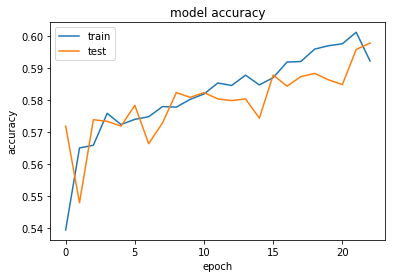

In [51]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

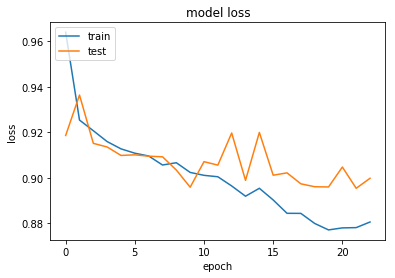

In [52]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
full_model.evaluate(X_test_inputs, y_test_enc)

2006/2006 [==============================] - 0s 112us/step


[0.8998042682588754, 0.5977068794213406]

In [54]:
full_model.evaluate(X_train_inputs, y_train_enc)

18054/18054 [==============================] - 2s 90us/step


[0.8473272730150769, 0.6195856873822976]

In [ ]:
# full_model.load_weights("./weights-improvement-23-0.60.hdf5")